# O Problema

Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde. 

A base de dados para este desafio pode ser algo como no exemplo a seguir:

<code>
idade,gênero,imc,filhos,fumante,região,encargos
</code>

Você precisa apenas alimentar ela com mais informações ou utilizar uma outra de sua preferência.

## Tarefas

### Exploração de Dados

Iniciando com os imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
dataset = pd.read_csv("encargos.csv")

# Definindo nossa coluna target
target_column = 'encargos'

dataset.info

<bound method DataFrame.info of       idade     gênero     imc  filhos fumante    região     encargos
0        19   feminino  27.900       0     sim  sudoeste  16884.92400
1        18  masculino  33.770       1     não   sudeste   1725.55230
2        28  masculino  33.000       3     não   sudeste   4449.46200
3        33  masculino  22.705       0     não  noroeste  21984.47061
4        32  masculino  28.880       0     não  noroeste   3866.85520
...     ...        ...     ...     ...     ...       ...          ...
1333     50  masculino  30.970       3     não  noroeste  10600.54830
1334     18   feminino  31.920       0     não  nordeste   2205.98080
1335     18   feminino  36.850       0     não   sudeste   1629.83350
1336     21   feminino  25.800       0     não  sudoeste   2007.94500
1337     61   feminino  29.070       0     sim  noroeste  29141.36030

[1338 rows x 7 columns]>

In [3]:
dataset.dtypes

idade         int64
gênero       object
imc         float64
filhos        int64
fumante      object
região       object
encargos    float64
dtype: object

In [4]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Como está a média dos encargos?

In [5]:
dataset[target_column].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: encargos, dtype: float64

Vamos procurar se temos valores nulos no nosso dataset?

In [6]:
dataset.isnull().sum()

idade       0
gênero      0
imc         0
filhos      0
fumante     0
região      0
encargos    0
dtype: int64

Podemos agora obter as colunas númericas e as categóricas, o que vai nos ajudar a saber quais colunas precisaremos padronizar e/ou encodar.

In [7]:
numeric_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_features, categorical_features

(['idade', 'imc', 'filhos', 'encargos'], ['gênero', 'fumante', 'região'])

Do nosso dataset numérico, como está a correlação dos nossos dados?

In [8]:
dataset_numerico = dataset[numeric_features]
corr_matrix = dataset_numerico.corr()
corr_matrix

,idade,imc,filhos,encargos
idade,1.000000,0.109272,0.042469,0.299008
imc,0.109272,1.000000,0.012759,0.198341
filhos,0.042469,0.012759,1.000000,0.067998
encargos,0.299008,0.198341,0.067998,1.000000


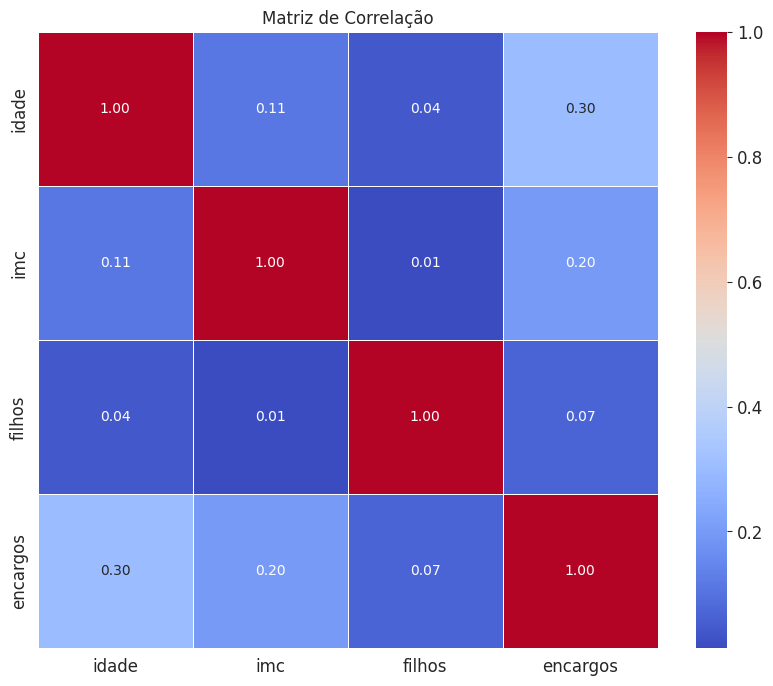

In [9]:
import seaborn as sns
# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

### Pré Processamento de Dados

Vamos iniciar com o pré processamentos do nosso dataset, realizando as nossas padronizações e encodeds.

In [10]:
from sklearn.model_selection import train_test_split

# Obtendos nossas variáveis X e y
X = dataset.drop(target_column, axis=1)
y = dataset[target_column]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_features, categorical_features

(['idade', 'imc', 'filhos'], ['gênero', 'fumante', 'região'])

Agora vamos splitar nossa base de treino e teste

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

E então podemos definir 2 pipelines para realizar as nossas transformações

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Tratamento para possíveis valores nulos e dimensionamento padronizado
numeric_transformer = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='mean')),
	('scaler', StandardScaler())
])

# Tratamento para codificação de variáveis categóricas
categorical_transformer = Pipeline(steps=[
	('encoder', OneHotEncoder(drop='first'))
])

Combinando nossas transformações

In [13]:
preprocessor = ColumnTransformer(
	transformers=[
    	('num', numeric_transformer, numeric_features),
    	('cat', categorical_transformer, categorical_features)
	]
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'imc', 'filhos']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['gênero', 'fumante', 'região'])])

Agora aplicaremos ao nosso dataset

In [14]:
X_train_processed = preprocessor.transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [15]:
preprocessor.get_feature_names_out()

array(['num__idade', 'num__imc', 'num__filhos', 'cat__gênero_masculino',
       'cat__fumante_sim', 'cat__região_noroeste', 'cat__região_sudeste',
       'cat__região_sudoeste'], dtype=object)

### Modelagem

Importando os nossos modelos que serão utilizados. Utilizaremos a validação cruzada e o tunning dos hyper parâmetros para obter a melhor configuração dos modelos.

In [16]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble._forest import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

# Definindo o número de kfolds com embaralhamento
folds = 5
kfold  = KFold(n_splits=folds, shuffle=True)

# Métrica de desempenho = melhor acurácia
# https://scikit-learn.org/stable/modules/model_evaluation.html
# gs_metric = make_scorer(mean_absolute_error, greater_is_better=False)
gs_metric = make_scorer(r2_score, greater_is_better=True)

# Controle de verbosidade
verbose_flag = 3

Configurando e avaliando o modelo de Regressão Linear

In [17]:
params = {"fit_intercept": [True, False],}

grid = GridSearchCV(estimator=LinearRegression(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')


# model_lr = LinearRegression(fit_intercept=True)
model_lr = grid.best_estimator_
model_lr

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'fit_intercept': True}
Best Cross-Validation Score: 0.73


LinearRegression()

Configurando e avaliando o modelo Lasso

In [18]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=Lasso(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_lasso = Lasso(alpha=10)
model_lasso = grid.best_estimator_
model_lasso

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'alpha': 100}
Best Cross-Validation Score: 0.73


Lasso(alpha=100)

Configurando e avaliando o modelo Ridge

In [19]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=Ridge(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_ridge = Ridge(alpha=0.0001)
model_ridge = grid.best_estimator_
model_ridge

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'alpha': 1.0}
Best Cross-Validation Score: 0.73


Ridge()

Configurando e avaliando o modelo Ridge

In [20]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

grid = GridSearchCV(estimator=ElasticNet(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_elastic = ElasticNet(alpha=0.0001)
model_elastic = grid.best_estimator_
model_elastic

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END fit_intercept=True;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 5/5] END fit_intercept=True;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END fit_intercept=False;, score=(train=0.645, test=0.609) total time=   0.0s
[CV 2/5] END fit_intercept=False;, score=(train=0.605, test=0.747) total time=   0.0s
[CV 3/5] END fit_intercept=False;, score=(train=0.643, test=0.614) total time=   0.0s
[CV 4/5] END fit_intercept=False;, score=(train=0.665, test=0.521) total time=   0.0s
[CV 5/5] END fit_intercept=False;, score=(train=0.634, test=0.650) total time=   0.0s
[CV 1/5] END ..alpha=0.0001;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 5/5] END ..alpha=0.0001;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END ....alpha=0.01;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 2/5] END ....alpha=0.01;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 3/5] END .

ElasticNet(alpha=0.001)

Configurando e avaliando o modelo DecisionTreeRegressor

In [21]:
params = {'max_depth': [d for d in range(1,16)], 'criterion': ['poisson', 'squared_error', 'friedman_mse', 'absolute_error']}

grid = GridSearchCV(estimator=DecisionTreeRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
best_params = grid.best_params_
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_dtr = DecisionTreeRegressor(max_depth=4)
model_dtr = grid.best_estimator_
model_dtr

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 2/5] END fit_intercept=True;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 2/5] END ..alpha=0.0001;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 3/5] END ...alpha=0.001;, score=(train=0.745, test=0.723) total time=   0.0s
[CV 5/5] END ....alpha=0.01;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END ....alpha=0.05;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 4/5] END ....alpha=0.05;, score=(train=0.761, test=0.658) total time=   0.0s
[CV 5/5] END ....alpha=0.05;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 4/5] END .....alpha=0.2;, score=(train=0.761, test=0.658) total time=   0.0s
[CV 5/5] END .....alpha=0.2;, score=(train=0.735, test=0.767) total time=   0.0s
[CV 1/5] END .....alpha=0.3;, score=(train=0.748, test=0.716) total time=   0.0s
[CV 2/5] END .....alpha=0.3;, score=(train=0.723, test=0.802) total time=   0.0s
[CV 4/5] END .....alpha=0.6;, score=(train=

DecisionTreeRegressor(criterion='poisson', max_depth=4)

Configurando e avaliando o modelo KNN

In [22]:
params = {'n_neighbors': [n for n in range(1,16)], 'weights': ["uniform", "distance"]}

grid = GridSearchCV(estimator=KNeighborsRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_knn = KNeighborsRegressor(n_neighbors=2, weights="distance")
model_knn = grid.best_estimator_
model_knn

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 5/5] END criterion=poisson, max_depth=2;, score=(train=0.821, test=0.830) total time=   0.0s
[CV 5/5] END criterion=poisson, max_depth=3;, score=(train=0.854, test=0.838) total time=   0.0s
[CV 1/5] END criterion=poisson, max_depth=4;, score=(train=0.875, test=0.828) total time=   0.0s
[CV 3/5] END criterion=poisson, max_depth=5;, score=(train=0.884, test=0.809) total time=   0.0s
[CV 4/5] END criterion=poisson, max_depth=5;, score=(train=0.897, test=0.750) total time=   0.0s
[CV 2/5] END criterion=poisson, max_depth=8;, score=(train=0.937, test=0.868) total time=   0.0s
[CV 3/5] END criterion=poisson, max_depth=8;, score=(train=0.942, test=0.721) total time=   0.0s
[CV 4/5] END criterion=poisson, max_depth=8;, score=(train=0.941, test=0.695) total time=   0.0s
[CV 5/5] END criterion=poisson, max_depth=8;, score=(train=0.940, test=0.777) total time=   0.0s
[CV 4/5] END criterion=poisson, max_depth=10;, score=(train=0.973

KNeighborsRegressor(n_neighbors=3, weights='distance')

Configurando o modelo RandomForestRegressor

In [23]:
params = {'n_estimators': [n for n in range(1,16)], 'max_depth': [n for n in range(1,16)]}

grid = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=params,
                    scoring=gs_metric,
					return_train_score=True,
                    cv=folds, n_jobs=4, verbose=verbose_flag)

grid.fit(X_train_processed, y_train)

# Selecionando os melhores hiperparametros com base nos dados de treino
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Cross-Validation Score: {grid.best_score_:.2f}')

# model_knn = KNeighborsRegressor(n_neighbors=2, weights="distance")
model_rf = grid.best_estimator_
model_rf

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV 3/5] END criterion=absolute_error, max_depth=15;, score=(train=0.997, test=0.618) total time=   0.0s
[CV 2/5] END n_neighbors=1, weights=uniform;, score=(train=0.996, test=0.694) total time=   0.0s
[CV 1/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.655) total time=   0.0s
[CV 1/5] END n_neighbors=2, weights=uniform;, score=(train=0.889, test=0.663) total time=   0.0s
[CV 2/5] END n_neighbors=2, weights=uniform;, score=(train=0.891, test=0.736) total time=   0.0s
[CV 1/5] END n_neighbors=3, weights=uniform;, score=(train=0.846, test=0.700) total time=   0.0s
[CV 2/5] END n_neighbors=3, weights=uniform;, score=(train=0.830, test=0.750) total time=   0.0s
[CV 2/5] END n_neighbors=4, weights=distance;, score=(train=0.998, test=0.782) total time=   0.0s
[CV 3/5] END n_neighbors=4, weights=distance;, score=(train=0.999, test=0.654) total time=   0.0s
[CV 4/5] END n_neighbors=4, weights=distance;, score

RandomForestRegressor(max_depth=4, n_estimators=14)

### Treinamento e avaliação do modelo

In [24]:
dic_models = {}

# Treinando modelo LR
model_lr.fit(X_train_processed, y_train)
y_pred_lr = model_lr.predict(X_test_processed)
lr_result = cross_val_score(model_lr, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["LR"] = lr_result.mean()

# Treinando modelo Lasso
model_lasso.fit(X_train_processed, y_train)
y_pred_lasso = model_lasso.predict(X_test_processed)
lasso_result = cross_val_score(model_lasso, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Lasso"] = lasso_result.mean()

# Treinando modelo Ridge
model_ridge.fit(X_train_processed, y_train)
y_pred_ridge = model_ridge.predict(X_test_processed)
ridge_result = cross_val_score(model_ridge, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Ridge"] = ridge_result.mean()

# Treinando modelo Elastic
model_elastic.fit(X_train_processed, y_train)
y_pred_elastic = model_elastic.predict(X_test_processed)
elastic_result = cross_val_score(model_elastic, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["Elastic"] = elastic_result.mean()

# Treinando modelo DTR
model_dtr.fit(X_train_processed, y_train)
y_pred_dtr = model_dtr.predict(X_test_processed)
dtr_result = cross_val_score(model_dtr, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["DTR"] = dtr_result.mean()

# Treinando modelo KNN
model_knn.fit(X_train_processed, y_train)
y_pred_knn = model_knn.predict(X_test_processed)
knn_result = cross_val_score(model_knn, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["KNN"] = knn_result.mean()

# Treinando modelo RF
model_rf.fit(X_train_processed, y_train)
y_pred_rf = model_rf.predict(X_test_processed)
rf_result = cross_val_score(model_rf, X_train_processed, y_train, cv=kfold, scoring=gs_metric)
dic_models["RF"] = knn_result.mean()

### Validação Estatística

Criando método para obter as métricas dos resultados dos modelos e imprimi-los

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def validade_model(model, y_test, y_pred_model, result):
    raiz_erro_medio_quadratico = np.sqrt(mean_squared_error(y_test, y_pred_model))
    erro_absoluto_medio = mean_absolute_error(y_test, y_pred_model)
    
    r_quadrado = result.mean()
    
    print(f"Modelo: {model}")
    # print(f"Coeficientes: {model.coef_}")
    print(f'Raiz Erro Médio Quadrático: {raiz_erro_medio_quadratico}')
    print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
    print(f'R² (coeficiente de determinação): {r_quadrado}')
    print("")

In [26]:
validade_model(model_lr, y_test, y_pred_lr, lr_result)

validade_model(model_lasso, y_test, y_pred_lasso, lasso_result)

validade_model(model_ridge, y_test, y_pred_ridge, ridge_result)

validade_model(model_elastic, y_test, y_pred_elastic, elastic_result)

validade_model(model_dtr, y_test, y_pred_dtr, dtr_result)

validade_model(model_knn, y_test, y_pred_knn, knn_result)

validade_model(model_rf, y_test, y_pred_rf, rf_result)

Modelo: LinearRegression()
Raiz Erro Médio Quadrático: 5796.284659276275
Erro Absoluto Médio: 4181.194473753653
R² (coeficiente de determinação): 0.7338953244381436

Modelo: Lasso(alpha=100)
Raiz Erro Médio Quadrático: 5853.722106648779
Erro Absoluto Médio: 4248.4924525349
R² (coeficiente de determinação): 0.7259362658179336

Modelo: Ridge()
Raiz Erro Médio Quadrático: 5800.464937731764
Erro Absoluto Médio: 4193.19535293527
R² (coeficiente de determinação): 0.7337339636127567

Modelo: ElasticNet(alpha=0.001)
Raiz Erro Médio Quadrático: 5798.463704441815
Erro Absoluto Médio: 4187.599367123343
R² (coeficiente de determinação): 0.7299019116622454

Modelo: DecisionTreeRegressor(criterion='poisson', max_depth=4)
Raiz Erro Médio Quadrático: 4592.764309715604
Erro Absoluto Médio: 2697.765430538481
R² (coeficiente de determinação): 0.8493261077695891

Modelo: KNeighborsRegressor(n_neighbors=3, weights='distance')
Raiz Erro Médio Quadrático: 6494.981673872454
Erro Absoluto Médio: 3633.195483431

Selecionando o melhor modelo

In [27]:
melhor_modelo = max(dic_models, key=dic_models.get)
print(f"O melhor modelo é : {melhor_modelo} com o valor: {dic_models[melhor_modelo]:.4f}")

O melhor modelo é : DTR com o valor: 0.8493


Testando o melhor modelo

In [28]:
def pred_custo_seguro(idade,genero,imc,filhos,fumante,regiao):
    data_row = {'idade': [idade], 'gênero': [genero], 'imc': [imc], 'filhos': [filhos], 'fumante': [fumante], 'região': [regiao]}
    data = pd.DataFrame(data_row)
    
    data_processed = preprocessor.transform(data)
    pred = model_dtr.predict(data_processed)
    valor = round(pred[0], 2)
    return valor

In [29]:
# mulher, nao fumante, nova, IMC Normal
pred_custo_seguro(idade = 18, genero = 'feminino', imc = 21, filhos = 0, fumante = 'não', regiao = 'sudeste')

2757.95

In [30]:
# mulher, fumante, nova, IMC Sobrepeso
pred_custo_seguro(idade = 23, genero = 'feminino', imc = 26, filhos = 0, fumante = 'sim', regiao = 'sudeste')

19598.17

In [31]:
# homem, não fumante, novo, IMC Normal
pred_custo_seguro(idade = 25, genero = 'masculino', imc = 23, filhos = 0, fumante = 'não', regiao = 'sudeste')

5703.34

In [32]:
# homem, fumante, velho, IMC Sobrepeso
pred_custo_seguro(idade = 60, genero = 'masculino', imc = 35, filhos = 0, fumante = 'sim', regiao = 'sudeste')

46920.63